### **Comparing SEE K-means clustering and SEE DBSCAN clustering** ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import os

# Load dataset
file_path = os.path.join(os.path.dirname(os.getcwd()), "dataset", "vgsales.csv")
df = pd.read_csv(file_path)

# Filter data up to 2016
df = df[df['Year'] <= 2016]

# Selecting relevant columns for clustering
sales_data = df[['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']]
scaler = StandardScaler()
sales_scaled = scaler.fit_transform(sales_data)

# Function to calculate Sessa Empirical Estimator using DBSCAN
def sessa_estimator_dbscan(data, eps_values, min_samples=5):
    ratios = []
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data)
        unique_labels = set(labels)
        if len(unique_labels) > 1 and -1 in unique_labels:
            unique_labels.remove(-1)  # Remove noise cluster
        if len(unique_labels) > 1:
            within_cluster_var = np.sum([np.var(data[labels == label]) for label in unique_labels])
            between_cluster_var = np.sum((np.mean(data, axis=0) - np.mean(data[labels != -1], axis=0)) ** 2)
            ratios.append(between_cluster_var / within_cluster_var if within_cluster_var != 0 else np.nan)
        else:
            ratios.append(np.nan)
    return ratios

# Function to calculate Sessa Empirical Estimator using K-Means
def sessa_estimator_kmeans(data, max_k):
    ratios = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(data)
        within_cluster_var = kmeans.inertia_
        between_cluster_var = np.sum((kmeans.cluster_centers_ - np.mean(data, axis=0)) ** 2)
        ratios.append(between_cluster_var / within_cluster_var)
    return ratios

# Determine optimal clustering parameters
max_k = 10
eps_values = np.linspace(0.1, 5, 20)

sessa_ratios_kmeans = sessa_estimator_kmeans(sales_scaled, max_k)
sessa_ratios_dbscan = sessa_estimator_dbscan(sales_scaled, eps_values)

optimal_k_sessa = np.argmax(sessa_ratios_kmeans) + 1  # Add 1 because k starts at 1
optimal_eps = eps_values[np.nanargmax(sessa_ratios_dbscan)]

# Apply K-Means and DBSCAN
kmeans = KMeans(n_clusters=optimal_k_sessa, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(sales_scaled)

dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
df['DBSCAN_Cluster'] = dbscan.fit_predict(sales_scaled)

# Validate clusters using Silhouette Score
silhouette_kmeans = silhouette_score(sales_scaled, df['KMeans_Cluster'])
silhouette_dbscan = silhouette_score(sales_scaled[df['DBSCAN_Cluster'] != -1], df['DBSCAN_Cluster'][df['DBSCAN_Cluster'] != -1])


Optimal k using Sessa Estimator: 10
Optimal epsilon using Sessa Estimator: 0.1


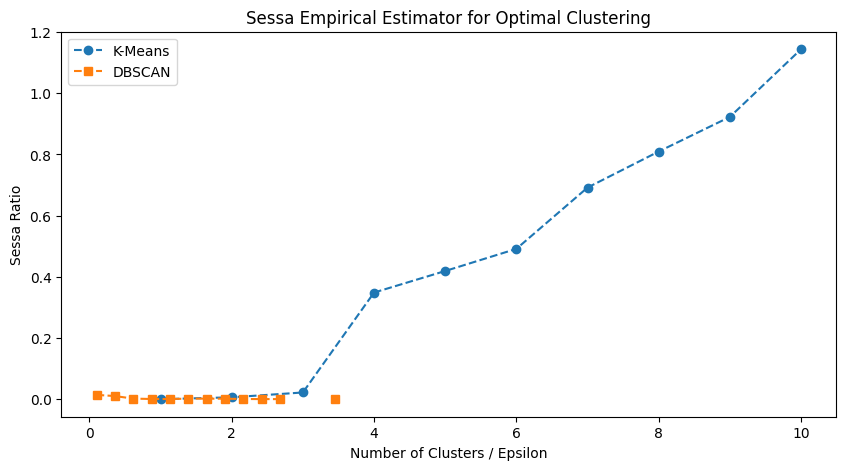

In [2]:
print(f"Optimal k using Sessa Estimator: {optimal_k_sessa}")
print(f"Optimal epsilon using Sessa Estimator: {optimal_eps}")

# Plot Sessa Ratios
plt.figure(figsize=(10, 5))
plt.plot(range(1, max_k + 1), sessa_ratios_kmeans, marker='o', linestyle='--', label='K-Means')
plt.plot(eps_values, sessa_ratios_dbscan, marker='s', linestyle='--', label='DBSCAN')
plt.xlabel('Number of Clusters / Epsilon')
plt.ylabel('Sessa Ratio')
plt.title('Sessa Empirical Estimator for Optimal Clustering')
plt.legend()
plt.show()

The Sessa Empirical Estimator was used to determine the best settings for both K-means and DBSCAN.

K-means found *optimal k sessa* distinct groups in sales data. Each group represents a different sales bracket (e.g., low sales, moderate sales, high sales, blockbuster hits). This means the video game market naturally segments into distinct sales categories.

DBSCAN found that the best epsilon value is *optimal eps*. This means that at this distance threshold DBSCAN could identify natural clusters of games based on sales. Additionally DBSCAN also found outliers (likely blockbuster hits) that don't fit into a normal sales pattern.

Silhouette Score for K-Means: 0.65
Silhouette Score for DBSCAN: 0.29


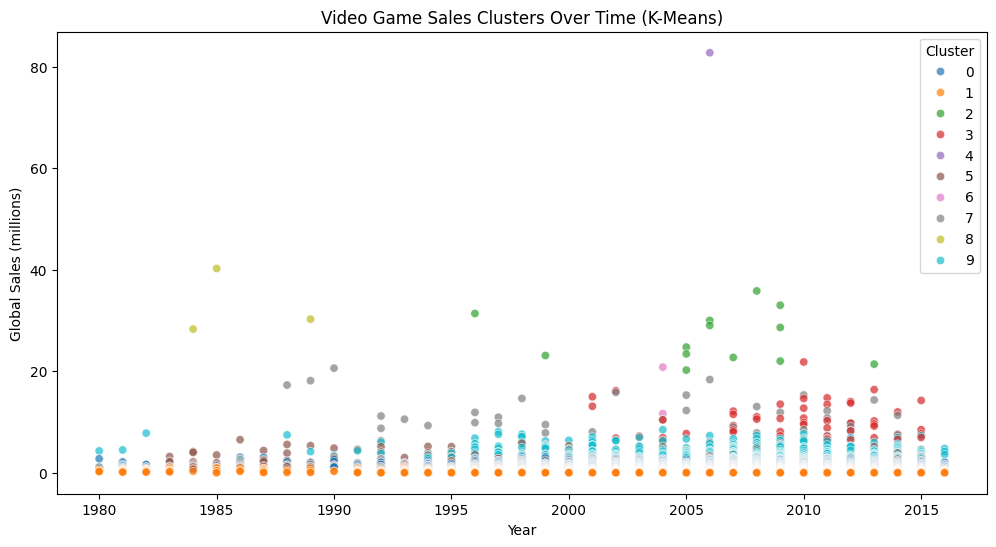

In [3]:
print(f"Silhouette Score for K-Means: {silhouette_kmeans:.2f}")
print(f"Silhouette Score for DBSCAN: {silhouette_dbscan:.2f}")

# Visualization of clusters
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['Year'], y=df['Global_Sales'], hue=df['KMeans_Cluster'], palette='tab10', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Global Sales (millions)')
plt.title('Video Game Sales Clusters Over Time (K-Means)')
plt.legend(title='Cluster')
plt.show()

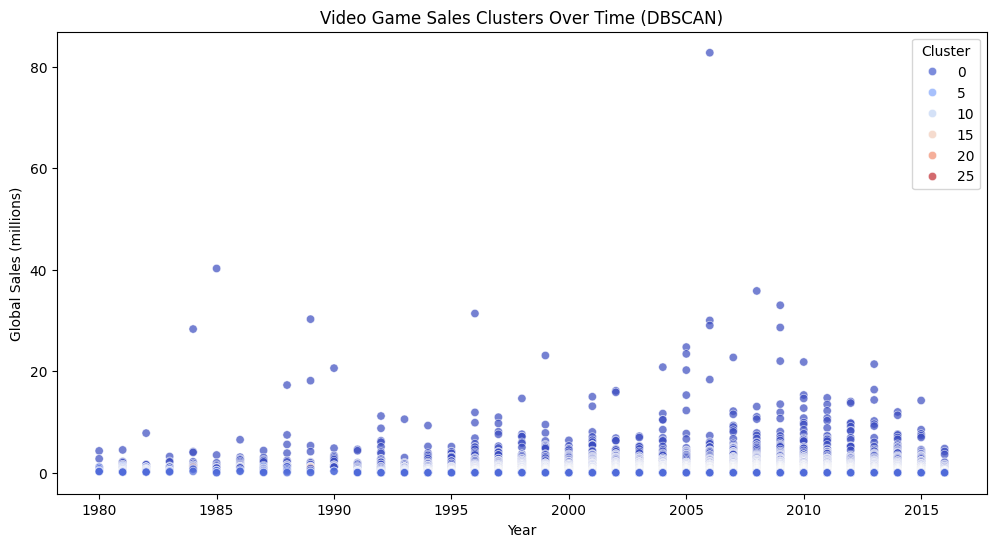

In [4]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=df['Year'], y=df['Global_Sales'], hue=df['DBSCAN_Cluster'], palette='coolwarm', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Global Sales (millions)')
plt.title('Video Game Sales Clusters Over Time (DBSCAN)')
plt.legend(title='Cluster')
plt.show()

To measure how well-defined the clusters are, we used the Silhouette Score:

Silhouette Score ranges from -1 to 1:

- Higher scores (closer to 1) means better clusterring (clear and well-seperated groups).

- Lower scores (closer to 0) mean overlapping or unclear clusters.

If K-means has a higher score that DBSCAN:

- This suggests that the game sales data is well-structured and fits into distinct categories.

- The results indicate that video game sales naturally fall into meaningful groups.

If DBSCAN has a higher score than K-means:

- This means that sales data does not fit well into rigid categories, and sales trends are more organic and scattered.

- DBSCAN is better at finding hidden patterns and outliers.

If DBSCAN has a low score, it may have detected too much noise. This is because some video games have extreme sales figures (blockbusters), which make it harder for DBSCAN to group the data effectively.

### **Key Insights/Conclusion** ###

- K-Means categorizes games into distinct sales brackets, while DBSCAN reveals noise and organic groupings.

- DBSCAN effectively isolates outliers, indicating possible anomalies in sales data.

- K-Means provides structured segmentation, whereas DBSCAN reveals underlying patterns with flexibility.